In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from rpy2.robjects.packages import importr

utils = importr("utils")
utils.chooseCRANmirror(ind=1)
utils.install_packages('lme4')

%load_ext rpy2.ipython

In [2]:
# Load data
utterances = pd.read_csv("results/intelligibility/utterances.csv")

# convert True/False to 0/1:
utterances.replace({False: 0, True: 1}, inplace=True)

utterances.head()


,response_latency,response_latency_follow_up,age,corpus,transcript_file,child_name,utt_child,utt_car,utt_child_follow_up,utt_child_intelligible,utt_car_intelligible,follow_up_intelligible,caregiver_response,caregiver_response_contingent
0,-998.0,-186.0,39.0,MPI-EVA-Manchester,/home/mitja/data/CHILDES/MPI-EVA-Manchester/El...,MPI-EVA-Manchester_Eleanor,oops your paint,no mess please,Daddy there's all water on your computer,1,1,1,1,1
1,251.0,3895.0,39.0,MPI-EVA-Manchester,/home/mitja/data/CHILDES/MPI-EVA-Manchester/El...,MPI-EVA-Manchester_Eleanor,Daddy there's all water on your computer,NaN,I want five,1,0,1,0,0
2,108.0,5.0,39.0,MPI-EVA-Manchester,/home/mitja/data/CHILDES/MPI-EVA-Manchester/El...,MPI-EVA-Manchester_Eleanor,if I could . very good,what number are you doing now Poppin,um these,1,1,1,1,1
3,35.0,90.0,39.0,MPI-EVA-Manchester,/home/mitja/data/CHILDES/MPI-EVA-Manchester/El...,MPI-EVA-Manchester_Eleanor,um these,xxx,I know who's that,1,0,1,0,0
4,11.0,4681.0,39.0,MPI-EVA-Manchester,/home/mitja/data/CHILDES/MPI-EVA-Manchester/El...,MPI-EVA-Manchester_Eleanor,big one,well whichever one you've got,mm no,1,1,1,1,1


In [3]:
# Some children have very few data points:
counts = utterances.groupby("child_name").size()
counts

child_name
Bernstein_Alice                    3
Bernstein_Anne                     1
Bernstein_Dale                     1
Bernstein_Gail                     3
Bernstein_Marie                    1
Braunwald_Laura                 8880
Brent_Alexander                  242
Brent_Allen                        3
Brent_Brooklyn                     8
Brent_Dillon                     814
Brent_Henry                      175
Brent_Jacob_Abernathy              4
Brent_Jaylen                      36
Brent_Maggie                     176
Brent_Miranda                    170
Brent_Morgan                     742
Brent_Tabitha                    335
Brent_Tabitha_Sims                 3
Brent_Timothy                    470
Brent_Tyrese                       6
Brent_Vas                         12
Brent_Vas_Coleman                109
Brent_Xavier                      12
MPI-EVA-Manchester_Eleanor     48244
MPI-EVA-Manchester_Fraser     103775
MacWhinney_Ross                12040
Peters_Seth                

In [4]:
# Exclude children with less than 100 datapoints:
child_names_enough_data = [name for name, count in counts.items() if count > 100]
print(len(utterances))
utterances = utterances[utterances.child_name.isin(child_names_enough_data)]
print(len(utterances))

293983
293890


## Caregiver Contingency

Text(0.5, 1.0, 'Caregiver contingency - by child')

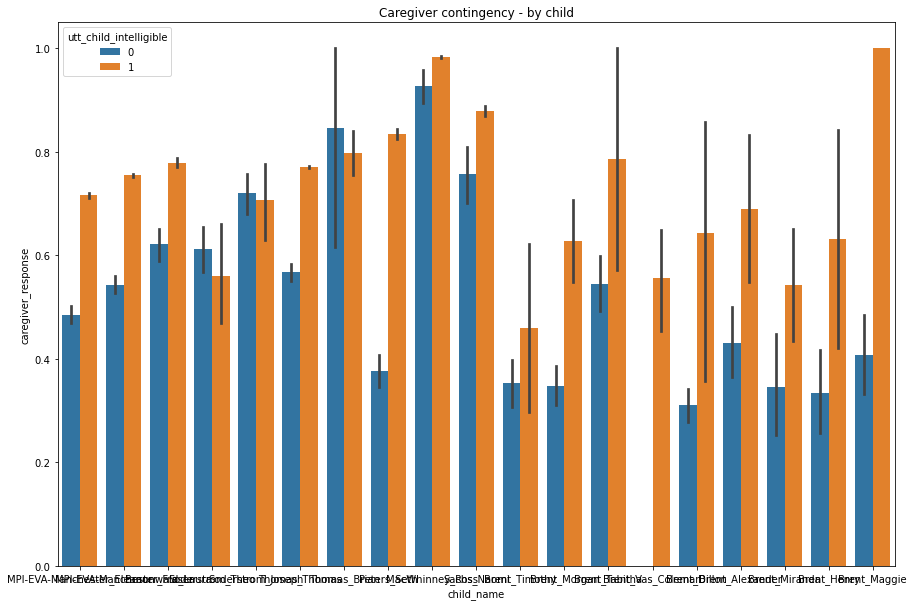

In [15]:
plt.rcParams['figure.figsize'] = [15, 10]
sns.barplot(
        data=utterances,
        x="child_name",
        y="caregiver_response",
        hue="utt_child_intelligible"
)
plt.title("Caregiver contingency - by child")

Text(0.5, 1.0, 'Caregiver contingency - by age')

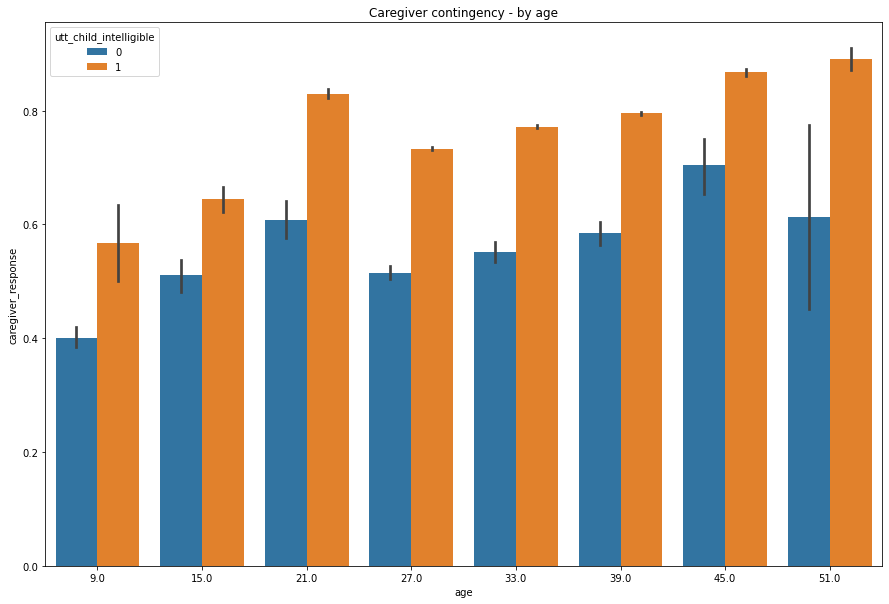

In [16]:
plt.rcParams['figure.figsize'] = [15, 10]
sns.barplot(
        data=utterances,
        x="age",
        y="caregiver_response",
        hue="utt_child_intelligible"
)
plt.title("Caregiver contingency - by age")

### GLM (with mixed effects)

In [6]:
%%R -i utterances
library(lme4)

# Caregiver contingency
m_caregiver_contingency<-glmer('caregiver_response ~ utt_child_intelligible * age + (1 | child_name)', data=utterances, family=binomial) #, control=glmerControl(optimizer="bobyqa",optCtrl=list(maxfun=2e5)))
print(summary(m_caregiver_contingency))


R[write to console]: Loading required package: Matrix



Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: caregiver_response ~ utt_child_intelligible * age + (1 | child_name)
   Data: utterances

      AIC       BIC    logLik  deviance  df.resid 
 315291.0  315344.0 -157640.5  315281.0    293885 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-9.2718  0.1177  0.5479  0.5979  1.5204 

Random effects:
 Groups     Name        Variance Std.Dev.
 child_name (Intercept) 0.5185   0.7201  
Number of obs: 293890, groups:  child_name, 19

Fixed effects:
                            Estimate Std. Error z value Pr(>|z|)    
(Intercept)                -0.616329   0.090618  -6.801 1.04e-11 ***
utt_child_intelligible      1.214334   0.058609  20.719  < 2e-16 ***
age                         0.037467   0.002003  18.706  < 2e-16 ***
utt_child_intelligible:age -0.008356   0.001966  -4.251 2.13e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 

In [7]:
%%R -i utterances
library(lme4)

# Caregiver contingency
m_caregiver_contingency<-glm('caregiver_response ~ utt_child_intelligible * age', data=utterances, family=binomial) #, control=glmerControl(optimizer="bobyqa",optCtrl=list(maxfun=2e5)))
print(summary(m_caregiver_contingency))


Call:
glm(formula = "caregiver_response ~ utt_child_intelligible * age", 
    family = binomial, data = utterances)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.9438   0.6179   0.7173   0.7714   1.3067  

Coefficients:
                            Estimate Std. Error z value Pr(>|z|)    
(Intercept)                -0.501473   0.042571 -11.780  < 2e-16 ***
utt_child_intelligible      0.812737   0.049255  16.501  < 2e-16 ***
age                         0.022515   0.001549  14.537  < 2e-16 ***
utt_child_intelligible:age  0.005212   0.001728   3.016  0.00256 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 327731  on 293889  degrees of freedom
Residual deviance: 321561  on 293886  degrees of freedom
AIC: 321569

Number of Fisher Scoring iterations: 4



In [8]:
%%R
tt <- getME(m_caregiver_contingency,"theta")
ll <- getME(m_caregiver_contingency,"lower")
min(tt[ll==0])

R[write to console]: Error in UseMethod("getME") : 
  no applicable method for 'getME' applied to an object of class "c('glm', 'lm')"

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv,  :
R[write to console]: 
 
R[write to console]:  Model failed to converge with max|grad| = 0.0316792 (tol = 0.002, component 1)

R[write to console]: 2: 
R[write to console]: In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv,  :
R[write to console]: 
 
R[write to console]:  Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?




Error in UseMethod("getME") : 
  no applicable method for 'getME' applied to an object of class "c('glm', 'lm')"


RInterpreterError: Failed to parse and evaluate line 'tt <- getME(m_caregiver_contingency,"theta")\nll <- getME(m_caregiver_contingency,"lower")\nmin(tt[ll==0])\n'.
R error message: 'Error in UseMethod("getME") : \n  no applicable method for \'getME\' applied to an object of class "c(\'glm\', \'lm\')"'

In [ ]:
%%R -i utterances
library(lme4)

utterances_child_intelligible = subset(utterances, utt_child_intelligible==1)

# Child contingency
m_child_contingency<-glmer('follow_up_intelligible ~ caregiver_response * age + (1 | child_name)', data=utterances_child_intelligible, family=binomial)
print(summary(m_child_contingency))